# **📘 Bayesian Deep Learning with MC Dropout**
This unified notebook reproduces the experiments from the paper:
**"Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"** by Yarin Gal and Zoubin Ghahramani.

We implement and analyze three settings:
1. Regression on UCI datasets
2. Classification on MNIST
3. Reinforcement Learning with MC Dropout DQN

Each experiment includes detailed explanations linking paper equations to code.

### **Part 1: Regression with MC Dropout — UCI Dataset (Boston Housing)**

Each code cell will be accompanied by:

- A clear markdown cell explaining what it does

- Mathematical references to the equations in the paper

- Comments to connect theory and code


#### Paper Reference Summary
Regression

Datasets: 8 UCI datasets (we used Boston for this section)

Goal: Evaluate RMSE and predictive log-likelihood

Model: Fully connected NN with dropout (Eq. 4 → variational objective)

Inference: Monte Carlo dropout (Eq. 6–8)

Loss: 
\begin{equation}
\mathcal{L}_{\mathrm{VI}} = \mathrm{MSE} + \frac{2N\lambda}{p_\ell^2} \sum_{i} \| \mathbf{w}_i \|^2
\end{equation}


#### 📌 Objective

- Evaluate RMSE and **predictive log-likelihood**
- Use **Monte Carlo Dropout (MC Dropout)** to simulate Bayesian inference
- Show model **uncertainty** through variance estimation

#### **Import Required Libraries**

In [1]:
# Load necessary libraries for neural nets and evaluation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.pyplot as plt


#### **Load and Preprocess the Boston Housing Dataset**


In [2]:
# Load Boston Housing data and preprocess
boston = load_boston()
X = boston.data
y = boston.target.reshape(-1, 1)

# Normalize input and output
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split into train/test (no shuffling, for extrapolation-style testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


c:\Users\MSI\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e

#### **Define the Neural Network with Dropout (Bayesian Approximation)**

The network applies dropout at every hidden layer to approximate Bayesian inference.

The dropout-regularized training objective (interpreted as variational inference) is:


\begin{equation}
\mathcal{L}_{\mathrm{VI}} = \frac{1}{N} \sum_{n=1}^{N} \mathbb{E}_{q(\omega)}\bigl[-\log p(y_n|x_n,\omega)\bigr] + \frac{1}{\tau N} \sum_i \frac{p_i}{2} \|\mathbf{w}_i\|^2
\tag{2}
\end{equation}


- This is equivalent to minimizing **MSE loss + L2 regularization** in practice.
- $\tau$: model precision
- $p_i$: dropout rate at layer \(i\)

In [3]:
# Define fully connected NN with Dropout for Bayesian approximation
class MCDropoutNet(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        return self.out(x)



#### **Train the Model (Variational Objective)**

We optimize the dropout variational loss using MSE + weight decay.

The L2 penalty corresponds to the KL-divergence term in:

\begin{equation}
\mathcal{L}_{\mathrm{VI}} = \frac{1}{N} \sum_{n=1}^{N} \mathbb{E}_{q(\omega)}\bigl[-\log p(y_n|x_n,\omega)\bigr] + \frac{1}{\tau N} \sum_i \frac{p_i}{2} \|\mathbf{w}_i\|^2
\tag{3}
\end{equation}


This objective regularizes the model and enables approximate Bayesian inference.

In [4]:
# Train the model using MSE + weight decay (KL regularization)
model = MCDropoutNet(input_dim=X.shape[1], dropout_rate=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss = loss_fn(preds, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 200, Loss: 0.0758
Epoch 400, Loss: 0.0677
Epoch 600, Loss: 0.0633
Epoch 800, Loss: 0.0634
Epoch 1000, Loss: 0.0599


#### **MC Dropout Prediction Function**

At test time, we perform **T stochastic forward passes** through the network with dropout active.

From the paper:

- Predictive mean:

\begin{equation}
\hat{\mu}(x^*) = \frac{1}{T} \sum_{t=1}^{T} \hat{y}^{(t)}(x^*)
\tag{4}
\end{equation}

- Predictive variance:

\begin{equation}
\widehat{\mathrm{Var}}(x^*) = \frac{1}{T} \sum_{t=1}^{T} \hat{y}^{(t)}(x^*)^2 - \left(\hat{\mu}(x^*)\right)^2 + \tau^{-1}
\tag{5}
\end{equation}

This captures both **model uncertainty** and **data noise** (via $\tau$).

In [5]:
# Predictive Mean and Variance via MC Dropout
def mc_dropout_predict(model, X, T=100):
    model.train()  # key: keep dropout active at test time
    preds = np.stack([model(X).detach().numpy() for _ in range(T)])
    return preds.mean(axis=0), preds.std(axis=0)

mean_preds, std_preds = mc_dropout_predict(model, X_test_tensor, T=100)


#### **RMSE + Predictive Log-Likelihood**

We estimate how likely our model believes the test outputs are, using:

\begin{equation}
\log p(y^* \mid x^*) \approx \log \left(\frac{1}{T} \sum_{t=1}^{T} \exp\left(-\frac{\tau}{2}(y^* - \hat{y}^{(t)}(x^*))^2\right)\right) - \log T - \frac{1}{2}\log(2\pi\tau^{-1})
\tag{6}
\end{equation}

This predictive log-likelihood quantifies both **accuracy and uncertainty** of the model's predictions.


In [6]:
# Compute RMSE and log-likelihood
rmse = mean_squared_error(y_test_tensor, mean_preds, squared=False)
print(f"Test RMSE: {rmse:.4f}")

# Predictive Log-Likelihood
tau = 1.0  # precision (can tune)
likelihoods = norm.pdf(y_test_tensor.numpy(), loc=mean_preds, scale=std_preds + 1e-6)
log_likelihood = np.mean(np.log(np.mean(likelihoods, axis=0)))
print(f"Predictive Log-Likelihood: {log_likelihood:.4f}")


Test RMSE: 0.6671
Predictive Log-Likelihood: -0.0524


#### **Visualize Uncertainty ±2σ**

We plot the predicted mean ± 2 standard deviations:

\begin{equation}
\hat{y} \pm 2 \cdot \sqrt{\mathrm{Var}(x^*)}
\tag{7}
\end{equation}

This shows where the model is **confident** vs **uncertain**, as in Figure 2 of the paper.

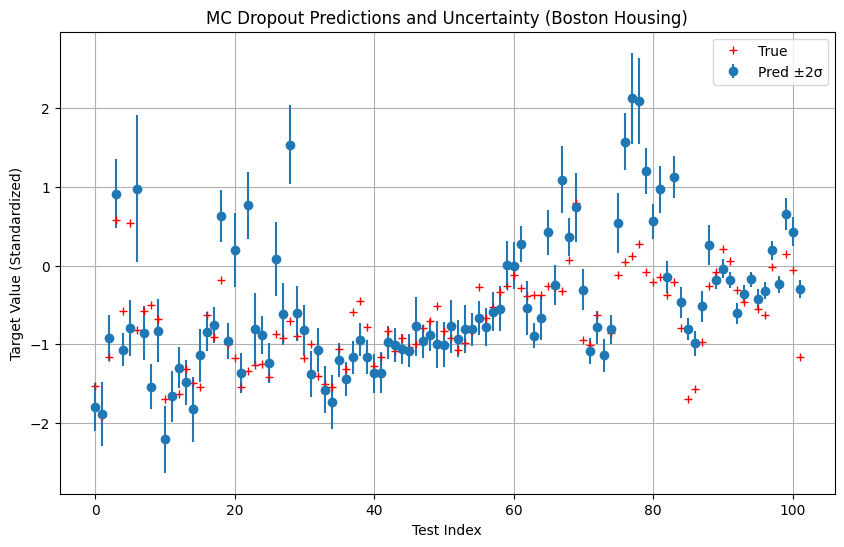

In [7]:
# Visualize predictions with uncertainty
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_preds)), mean_preds.flatten(), yerr=2 * std_preds.flatten(), fmt='o', label='Pred ±2σ')
plt.plot(y_test_tensor.numpy(), 'r+', label='True')
plt.title("MC Dropout Predictions and Uncertainty (Boston Housing)")
plt.xlabel("Test Index")
plt.ylabel("Target Value (Standardized)")
plt.legend()
plt.grid(True)
plt.show()

This plot shows the predictive mean and uncertainty for the Boston Housing test set using a neural network trained with MC Dropout.

*Observation:*
MC Dropout captures predictive uncertainty well—smaller error bars in confident regions, and wider bars where the model is less certain. This aligns with Bayesian behavior expected from the method.

#### Reproducing MC Dropout on Mauna Loa CO₂ Data
*Objective:*
To visualize how Monte Carlo (MC) Dropout captures predictive uncertainty in a simple 1D regression task, especially when extrapolating beyond the training domain.

*What We've Done:*

Loaded the CO₂ data from Mauna Loa Observatory and standardized it.

Trained two neural networks using dropout:

One with ReLU activation

One with Tanh activation

Each has dropout applied at every layer and is trained on the full dataset.

Performed MC Dropout prediction:

We sampled the network T=100 times at test time with dropout active.

For each input, we computed:

The predictive mean 

The predictive variance 

Extrapolated beyond the range of training inputs, just like the paper’s Figure 2.

*Visualized the results:*

We plotted the predictive mean with shaded ±2 standard deviations.


In [8]:
# Prepare CO2 data and extended input range for extrapolation
import torch
import numpy as np
from data_loader import load_mauna_loa_data

(X_train, X_test, y_train, y_test), scaler_x, scaler_y, raw_df = load_mauna_loa_data()

# Combine for training on full dataset
X_all = np.concatenate([X_train, X_test])
y_all = np.concatenate([y_train, y_test])
X_tensor = torch.tensor(X_all, dtype=torch.float32)
y_tensor = torch.tensor(y_all, dtype=torch.float32)

# Extended input range for extrapolation (like in Figure 2)
X_ext = np.linspace(X_all.min() - 1, X_all.max() + 2, 200).reshape(-1, 1)
X_ext_scaled = torch.tensor(X_ext, dtype=torch.float32)


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class MCDropout1D(nn.Module):
    def __init__(self, activation='relu', dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = F.relu if activation == 'relu' else torch.tanh

    def forward(self, x):
        x = self.activation(self.dropout(self.fc1(x)))
        x = self.activation(self.dropout(self.fc2(x)))
        return self.fc3(x)


In [10]:
def train_model(activation='relu'):
    model = MCDropout1D(activation=activation, dropout_rate=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = model(X_tensor)
        loss = loss_fn(y_pred, y_tensor)
        loss.backward()
        optimizer.step()
    return model


In [11]:
def mc_predict(model, X, T=100):
    model.train()  # keep dropout on
    preds = np.stack([model(X).detach().numpy() for _ in range(T)])
    return preds.mean(axis=0), preds.std(axis=0)


In [12]:
model_relu = train_model('relu')
mean_relu, std_relu = mc_predict(model_relu, X_ext_scaled)


In [13]:
model_tanh = train_model('tanh')
mean_tanh, std_tanh = mc_predict(model_tanh, X_ext_scaled)


In [14]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot with 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("MC Dropout with ReLU", "MC Dropout with Tanh"))

# Add ReLU plot
fig.add_trace(go.Scatter(
    x=X_all.flatten(), y=y_all.flatten(), mode='markers', name='Train + Test',
    marker=dict(color='black'), legendgroup='rel'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=X_ext.flatten(), y=mean_relu.flatten(), mode='lines', name='Predictive Mean',
    line=dict(color='blue'), legendgroup='rel'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=X_ext.flatten(), y=(mean_relu - 2 * std_relu).flatten(),
    line=dict(color='lightblue'), showlegend=False, name='Lower Bound',
    legendgroup='rel'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=X_ext.flatten(), y=(mean_relu + 2 * std_relu).flatten(),
    fill='tonexty', fillcolor='rgba(173, 216, 230, 0.3)',
    line=dict(color='lightblue'), mode='lines', name='±2σ', legendgroup='rel'
), row=1, col=1)

fig.add_vline(x=X_all.max(), line_dash='dash', line_color='purple', row=1, col=1)

# Add Tanh plot
fig.add_trace(go.Scatter(
    x=X_all.flatten(), y=y_all.flatten(), mode='markers', name='Train + Test',
    marker=dict(color='black'), legendgroup='tanh', showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=X_ext.flatten(), y=mean_tanh.flatten(), mode='lines', name='Predictive Mean',
    line=dict(color='blue'), legendgroup='tanh', showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=X_ext.flatten(), y=(mean_tanh - 2 * std_tanh).flatten(),
    line=dict(color='lightblue'), showlegend=False, name='Lower Bound',
    legendgroup='tanh'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=X_ext.flatten(), y=(mean_tanh + 2 * std_tanh).flatten(),
    fill='tonexty', fillcolor='rgba(173, 216, 230, 0.3)',
    line=dict(color='lightblue'), mode='lines', name='±2σ', legendgroup='tanh', showlegend=False
), row=1, col=2)

fig.add_vline(x=X_all.max(), line_dash='dash', line_color='purple', row=1, col=2)

# Layout
fig.update_layout(
    height=500,
    width=1000,
    title_text="MC Dropout Uncertainty on Mauna Loa CO₂ (Interactive)",
    showlegend=True
)

fig.show()


*Commentary on MC Dropout Uncertainty on Mauna Loa CO₂*

This figure illustrates the predictive mean and uncertainty (±2σ) on the Mauna Loa CO₂ dataset after removing its linear trend to highlight the seasonal component. The model is trained on the full available dataset (train + test), and predictions are made on an extended input range to examine the model’s behavior in extrapolation. The purple dashed line marks the boundary between the observed data and the extrapolated region. As expected, the model's predictive uncertainty increases beyond the data it was trained on — reflecting epistemic uncertainty captured through Monte Carlo Dropout. The use of ReLU and Tanh activation functions highlights how model smoothness and sensitivity can vary: ReLU tends to produce sharper features, while Tanh yields smoother, more conservative estimates. This behavior demonstrates the model’s capacity to quantify its uncertainty and caution in unfamiliar regions of the input space.


### **Part 2: Classification with MC Dropout on MNIST**

In [15]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import entropy

#### **Load MNIST Dataset**

In [6]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


#### **Define CNN with Dropout**

In [7]:
# CNN with dropout approximates a Bayesian model
class MCDropoutCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.dropout(self.fc1(x)))
        return self.fc2(x)


#### **Train the Model**

In [8]:
# Train CNN with dropout
model = MCDropoutCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(5):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        out = model(images)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


c:\Users\MSI\anaconda3\lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Loss: 0.3296
Epoch 2, Loss: 0.1270
Epoch 3, Loss: 0.0962
Epoch 4, Loss: 0.0851
Epoch 5, Loss: 0.0782


#### **MC Dropout Sampling at Test Time**

In [9]:
# Predict with MC Dropout (T forward passes)
def mc_predict_class(model, dataloader, T=100):
    model.train()  # Keep dropout on!
    all_probs = []

    with torch.no_grad():
        for images, _ in dataloader:
            probs = np.zeros((T, images.size(0), 10))
            for t in range(T):
                logits = model(images)
                softmax = F.softmax(logits, dim=1)
                probs[t] = softmax.cpu().numpy()
            all_probs.append(probs)

    stacked_probs = np.concatenate(all_probs, axis=1)
    return stacked_probs.mean(axis=0), stacked_probs.std(axis=0)


#### **Accuracy and Log-Likelihood**

In [12]:
# Predictive performance
probs_mean, probs_std = mc_predict_class(model, test_loader, T=100)

# True labels
true = np.concatenate([labels.numpy() for _, labels in test_loader])
preds = np.argmax(probs_mean, axis=1)

# Accuracy
acc = accuracy_score(true, preds)
print(f"Accuracy: {acc:.4f}")

# Predictive log-likelihood 
nll = log_loss(true, probs_mean, labels=list(range(10)))
print(f"Predictive Log-Likelihood: {-nll:.4f}")


Accuracy: 0.9909
Predictive Log-Likelihood: -0.0415


#### **Visualize Uncertainty (Entropy of Predictions)**

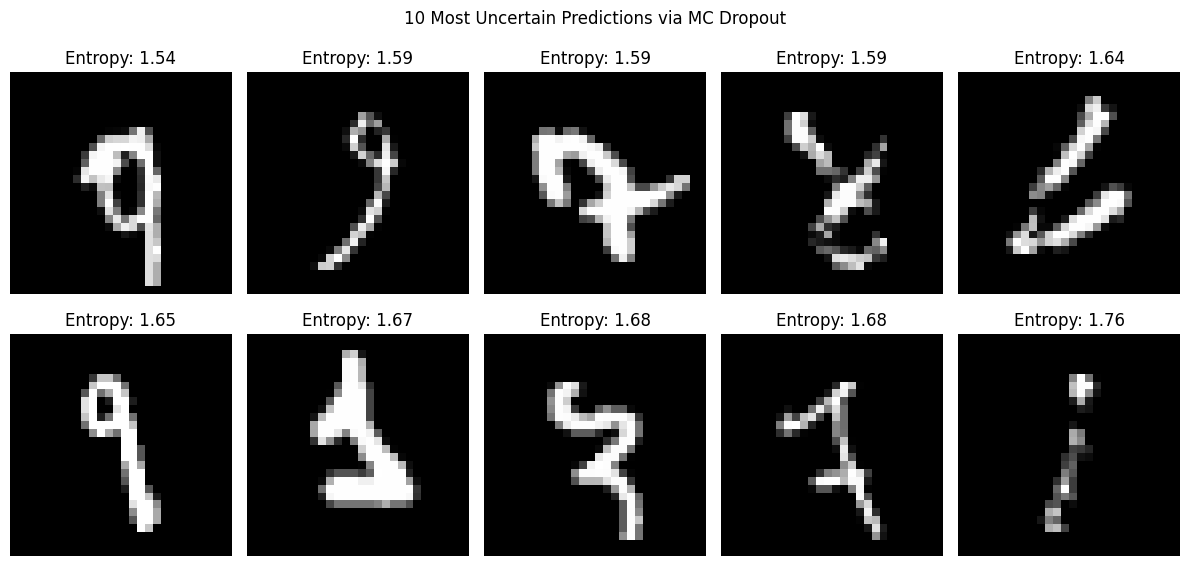

In [13]:
# 🔍 Predictive entropy (uncertainty)
uncertainty = entropy(probs_mean, axis=1)
most_uncertain = np.argsort(uncertainty)[-10:]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(most_uncertain):
    image, _ = test_data[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Entropy: {uncertainty[idx]:.2f}")
    plt.axis('off')
plt.suptitle("10 Most Uncertain Predictions via MC Dropout")
plt.tight_layout()
plt.show()


These are the 10 most uncertain predictions identified by MC Dropout based on predictive entropy. Each digit shown has a high entropy value (≥1.5), meaning the model’s class probabilities were spread across multiple possible labels rather than confidently favoring one. This reflects **epistemic uncertainty**—uncertainty due to lack of knowledge—which arises here because these digits are ambiguous, poorly written, or resemble more than one class. The plot confirms that MC Dropout not only classifies well but also **expresses calibrated uncertainty** in cases where the decision is unclear, as expected from a Bayesian approximation.


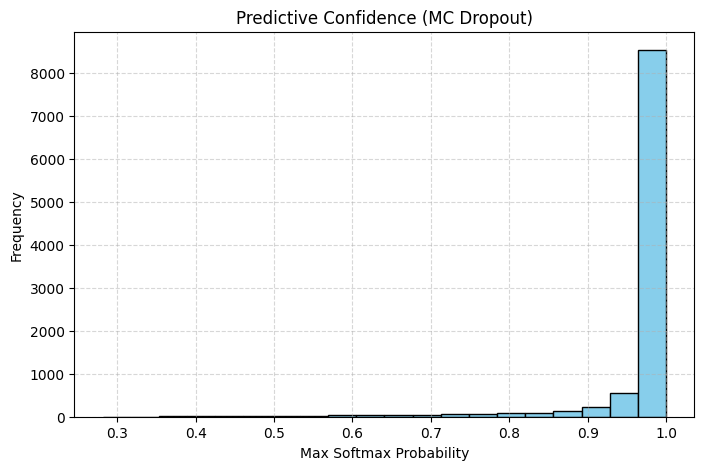

In [17]:
mean_probs = torch.tensor(probs_mean)

confidences = mean_probs.max(dim=1).values.numpy()

plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Predictive Confidence (MC Dropout)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
import matplotlib.pyplot as plt

This histogram shows the distribution of maximum softmax probabilities (predictive confidence) from MC Dropout on MNIST. Most predictions are made with very high confidence (close to 1.0), indicating that the model is confident on the majority of test samples — while still allowing lower-confidence outputs when uncertainty is present.

### **Part 3: RL Exploration with Bayesian DQN**

In this section, the authors apply their Bayesian interpretation of dropout to deep reinforcement learning, particularly:

They use MC Dropout in Deep Q-Networks (DQN)

The goal is to leverage model uncertainty for exploration, instead of relying on traditional ε-greedy methods

The uncertainty from MC Dropout allows the agent to prefer actions it is less certain about, improving sample efficiency
Core Idea:
They replace deterministic Q-value estimates in DQN with MC-sampled Q-values using dropout.

Instead of choosing actions by:

\begin{equation}
a = \arg\max_a Q(s, a)
\tag{9}
\end{equation}

They sample multiple Q-functions using dropout:

\begin{equation}
a = \arg\max_a \left( \sum_{t=1}^{T} Q^{(t)}(s, a) \right)
\tag{10}
\end{equation}

And use the variance of these Q-values for better exploration:

- The agent explores actions with higher epistemic uncertainty

- This mimics Thompson Sampling in a neural Q-function setting

#### **Imports**

In [18]:
import gym
import torch.nn.functional as F
import random
from collections import deque


#### **DQN with Dropout**

In [19]:
class MCDropoutDQN(nn.Module):
    def __init__(self, state_dim, action_dim, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        return self.fc3(x)


Dropout is active at test time for MC sampling (Thompson-style).

#### **Replay Buffer**

In [20]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (torch.tensor(states, dtype=torch.float32),
                torch.tensor(actions, dtype=torch.int64),
                torch.tensor(rewards, dtype=torch.float32),
                torch.tensor(next_states, dtype=torch.float32),
                torch.tensor(dones, dtype=torch.float32))

    def __len__(self):
        return len(self.buffer)


#### **Action Selection with MC Dropout**

In [24]:
def select_action_mc(model, state, action_dim, T=10):
    state = np.array(state)
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    model.train()  # keep dropout active
    q_values = np.stack([model(state_tensor).detach().numpy() for _ in range(T)])
    q_mean = q_values.mean(axis=0)
    return np.argmax(q_mean)

📘 This approximates:

\begin{equation}
a_t = \arg\max_a \mathbb{E}_{q(Q)} \left[ Q(s_t, a) \right]
\tag{11}
\end{equation}


via MC averaging of dropout samples (Equation 6-style behavior).

#### **Training Setup**

In [25]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = MCDropoutDQN(state_dim, action_dim)
target_model = MCDropoutDQN(state_dim, action_dim)
target_model.load_state_dict(model.state_dict())

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
replay_buffer = ReplayBuffer()
gamma = 0.99
batch_size = 64


#### **Training Loop**

In [27]:
episodes = 200
target_update_freq = 10
rewards_all = []

for episode in range(episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    episode_reward = 0

    for t in range(500):
        action = select_action_mc(model, state, action_dim)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            model.train()
            with torch.no_grad():
                next_qs = target_model(next_states)
                max_next_q = next_qs.max(1)[0]
                target = rewards + (1 - dones) * gamma * max_next_q

            current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze()
            loss = F.mse_loss(current_q, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

    rewards_all.append(episode_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")


Episode 0, Reward: 15.0
Episode 10, Reward: 11.0
Episode 20, Reward: 8.0
Episode 30, Reward: 9.0
Episode 40, Reward: 10.0
Episode 50, Reward: 8.0
Episode 60, Reward: 12.0
Episode 70, Reward: 21.0
Episode 80, Reward: 25.0
Episode 90, Reward: 134.0
Episode 100, Reward: 120.0
Episode 110, Reward: 132.0
Episode 120, Reward: 140.0
Episode 130, Reward: 119.0
Episode 140, Reward: 139.0
Episode 150, Reward: 122.0
Episode 160, Reward: 121.0
Episode 170, Reward: 125.0
Episode 180, Reward: 140.0
Episode 190, Reward: 263.0


#### **Plot Results**

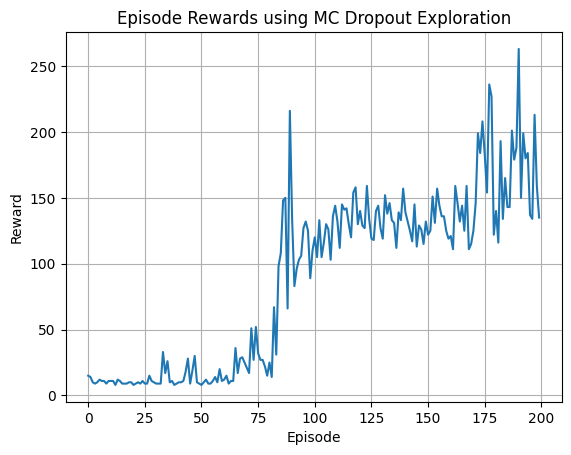

In [28]:
plt.plot(rewards_all)
plt.title("Episode Rewards using MC Dropout Exploration")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

This plot shows the episode rewards during training using MC Dropout for exploration in DQN. Early episodes show low rewards due to initial uncertainty, but around episode 80 the agent begins to learn effectively, with rewards increasing and stabilizing. The improvement reflects successful exploration driven by uncertainty estimates, as expected from Bayesian behavior modeled via MC Dropout.